## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Mounted at /content/drive


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 1.8 MB/s 
     |████████████████████████████████| 70 kB 6.5 MB/s 
     |████████████████████████████████| 1.1 MB 33.6 MB/s 
     |████████████████████████████████| 112 kB 62.9 MB/s 
     |████████████████████████████████| 45 kB 2.9 MB/s 
     |████████████████████████████████| 288 kB 81.6 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 271 kB 82.8 MB/s 
     |████████████████████████████████| 144 kB 86.0 MB/s 
     |████████████████████████████████| 749 kB 58.6 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.sats2backtest as s2b
import src.timeutils as tu

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (170958, 8)


### Generate Candles and build features from technical analysis

In [5]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()

# Generate normalized timeseries

In [6]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

ts_btc.x_candles
ts_btc.x_time
ts_btc.y[-10:]

Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 9)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


[0.37173570423785535,
 0.3712351192508525,
 0.371802807027128,
 0.37295939689433366,
 0.3727701979850954,
 0.3724915893892008,
 0.3725139873351453,
 0.3721737388636229,
 0.37303979277347576,
 0.3731663502729181]

## Train CNN-LSTM model using full or part of data set

In [7]:
btc_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.95)
btc_model.sats2model()

In [8]:
datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')

'220708_18_30'

In [9]:
MODELDATE_TO_SAVE = datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')
PRESAVED_MODELDATE = "220708_18_30"

if PRESAVED_MODELDATE == MODELDATE_TO_SAVE :
  model_name = f"model/LSTM_CNN_pretrained_{MODELDATE_TO_SAVE}"
else:
  model_name = "model/LSTM_CNN_model"

btc_model.sats2train(model_name, save_model = True, epochs=20)

Epoch 1/20
12/12 [==============================] - 30s 501ms/step - loss: 0.1964 - val_loss: 0.1866
Epoch 2/20
12/12 [==============================] - 1s 100ms/step - loss: 0.0542 - val_loss: 0.0733
Epoch 3/20
12/12 [==============================] - 1s 102ms/step - loss: 0.0347 - val_loss: 0.0280
Epoch 4/20
12/12 [==============================] - 1s 109ms/step - loss: 0.0171 - val_loss: 0.0078
Epoch 5/20
12/12 [==============================] - 1s 102ms/step - loss: 0.0143 - val_loss: 0.0245
Epoch 6/20
12/12 [==============================] - 1s 91ms/step - loss: 0.0226 - val_loss: 0.0119
Epoch 7/20
12/12 [==============================] - 1s 92ms/step - loss: 0.0469 - val_loss: 0.0334
Epoch 8/20
12/12 [==============================] - 1s 92ms/step - loss: 0.0365 - val_loss: 0.0623
Epoch 9/20
12/12 [==============================] - 1s 92ms/step - loss: 0.0231 - val_loss: 0.0371
Epoch 10/20
12/12 [==============================] - 1s 92ms/step - loss: 0.0156 - val_loss: 0.0168
Epo

INFO:tensorflow:Assets written to: model/LSTM_CNN_pretrained_220708_18_30/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_pretrained_220708_18_30/assets


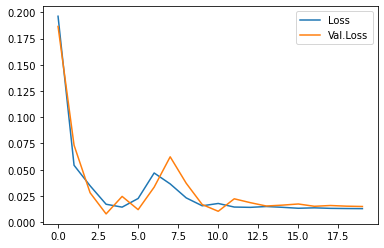

In [10]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

### Retrain for longer

In [11]:
btc_model.sats2train(model_name, save_model = True, epochs=500)

Epoch 1/500
12/12 [==============================] - 1s 106ms/step - loss: 0.0128 - val_loss: 0.0130
Epoch 2/500
12/12 [==============================] - 1s 105ms/step - loss: 0.0121 - val_loss: 0.0146
Epoch 3/500
12/12 [==============================] - 1s 92ms/step - loss: 0.0125 - val_loss: 0.0122
Epoch 4/500
12/12 [==============================] - 1s 102ms/step - loss: 0.0118 - val_loss: 0.0141
Epoch 5/500
12/12 [==============================] - 1s 93ms/step - loss: 0.0125 - val_loss: 0.0102
Epoch 6/500
12/12 [==============================] - 1s 101ms/step - loss: 0.0112 - val_loss: 0.0127
Epoch 7/500
12/12 [==============================] - 1s 94ms/step - loss: 0.0125 - val_loss: 0.0098
Epoch 8/500
12/12 [==============================] - 1s 104ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 9/500
12/12 [==============================] - 1s 93ms/step - loss: 0.0120 - val_loss: 0.0106
Epoch 10/500
12/12 [==============================] - 1s 103ms/step - loss: 0.0110 - val_loss: 

INFO:tensorflow:Assets written to: model/LSTM_CNN_pretrained_220708_18_30/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_pretrained_220708_18_30/assets


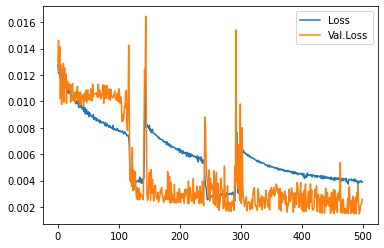

In [12]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [13]:
btc_model.sats2pred()

In [14]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(btc_model.scaler, ts_btc.candles, btc_model.preds)

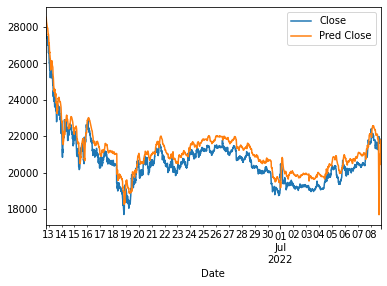

In [15]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = 1)
df_preds_true.dropna().plot()

## Test on pretrained model

In [16]:
USE_PRETRAINED = True

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.95)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = True)
loaded_model.preds

array([[0.4342301 ],
       [0.4342429 ],
       [0.43422824],
       ...,
       [0.36978978],
       [0.37289277],
       [0.37473652]], dtype=float32)

In [17]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(loaded_model.scaler, ts_btc.candles, loaded_model.preds)

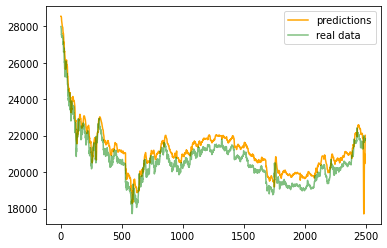

In [18]:
plt.plot(preds, color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point+ts_btc.step_back:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

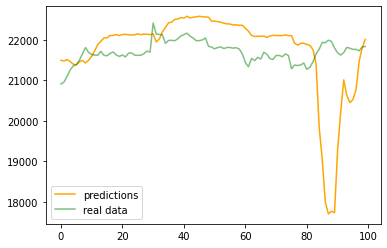

In [19]:
plt.plot(preds[-100:], color='orange', label='predictions')
plt.plot(true_vals[-100:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

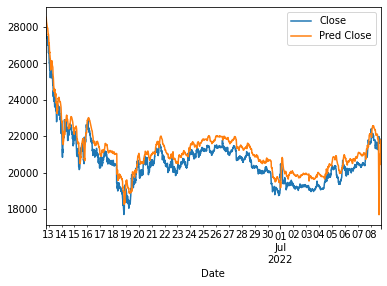

In [20]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = 1)
df_preds_true.dropna().plot()

In [21]:
df_preds_true.dropna()

,Close,Pred Close
Date,,
2022-06-12 18:30:00,27914.27,28545.842041
2022-06-12 18:45:00,27908.06,28547.249531
2022-06-12 19:00:00,27842.25,28545.639100
2022-06-12 19:15:00,27533.67,28515.008178
2022-06-12 19:30:00,27546.12,28485.624359
...,...,...
2022-07-08 17:30:00,21765.01,20453.298532
2022-07-08 17:45:00,21767.47,20529.879109
2022-07-08 18:00:00,21730.10,20774.890476


In [22]:
np.array(true_vals[btc_model.split_point+ts_btc.step_back+1:])

array([27914.27, 27908.06, 27842.25, ..., 21730.1 , 21825.22, 21839.12])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
/content/drive/MyDrive/Colab Notebooks/sats4u/src/sats2backtest.py:216: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes[1].stem(wallet_hist_df.index, wallet_hist_df.iloc[:, 1])


Initial time 2022-06-12 18:30:00
Final time 2022-07-08 18:30:00
Fee: 0.025
----------------------
Buy      2103 ( 1114 ok 989 ko )
Avg PCT gain: 1.0033762573346539
Avg PCT loss: 0.9968622933184261
Wins  PCT   0.5297194484070376
Avg PCT Gain.    1.0033762573346539
No-op    0
Wallet   9647.104250000004
Drawback -927.1227499999984
Kelly Fraction    0.06249197941216833
Total earned 9647.104250000004


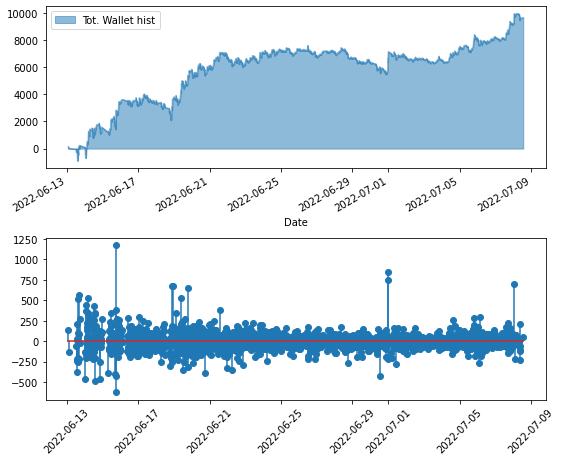

In [23]:
wallet_hist_df, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna(), step_back=+ 20,
                                                    long_short = "long", fee=0.025, cutoff_long = 5. ,cutoff_short = 5.0)
s2b.show_backtest_results(wallet,wallet_hist_df)